# Assignment 1: Decoding States

---

## Task 5) Dual-Tone Multi-Frequency

[Dual-tone multi-frequency DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) signaling is an old way of transmitting dial pad keystrokes over the phone.
Each key/symbol is assigned a frequency pair: `[(1,697,1209), (2,697,1336), (3,697,1477), (A,697,1633), (4,770,1209), (5,770,1336), (6,770,1477), (B,770,1633), (7,852,1209), (8,852,1336), (9,852,1477), (C,852,1633), (*,941,1209), (0,941,1336), (#,941,1477), (D,941,1633)]`.
You can generate some DTMF sequences online, eg. <https://www.audiocheck.net/audiocheck_dtmf.php>

### Features

For feature computation, use librosa to compute the power spectrum (`librosa.stft` and `librosa.amplitude_to_db`), and extract the approx. band energy for each relevant frequency.

> Note: It's best to identify silence by the overall spectral energy and to normalize the band energies to sum up to one.

### Decoding

To decode DTMF sequences, we can use again dynamic programming, this time applied to states rather than edits.
For DTMF sequences, consider a small, fully connected graph that has 13 states: 0-9, A-D, \*, \# and _silence_.
As for the DP-matrix: the rows will denote the states and the columns represent the time; we will decode left-to-right (ie. time-synchronous), and at each time step, we will have to find the best step forward.
The main difference to edit distances or DTW is, that you may now also "go up" in the table, ie. change state freely.
For distance/similarity, use a template vector for each state that has `.5` for those two bins that need to be active.

When decoding a sequence, the idea is now that we remain in one state as long as the key is pressed; after that, the key may either be released (and the spectral energy is close to 0) hence we're in pause, or another key is pressed, hence it's a "direct" transition.
Thus, from the backtrack, collapse the sequence by digit and remove silence, eg. `44443-3-AAA` becomes `433A`.

---

### Preparation

In [1]:
import librosa as lr
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
### Notice: librosa defaults to 22.050 Hz sample rate; adjust if needed!

DTMF_TONES = [
    ('1', 697, 1209), 
    ('2', 697, 1336), 
    ('3', 697, 1477), 
    ('A', 697, 1633),
    ('4', 770, 1209),
    ('5', 770, 1336),
    ('6', 770, 1477),
    ('B', 770, 1633),
    ('7', 852, 1209),
    ('8', 852, 1336),
    ('9', 852, 1477),
    ('C', 852, 1633),
    ('*', 941, 1209),
    ('0', 941, 1336),
    ('#', 941, 1477),
    ('D', 941, 1633)
]

### Implement the Decoding

reference spectra:


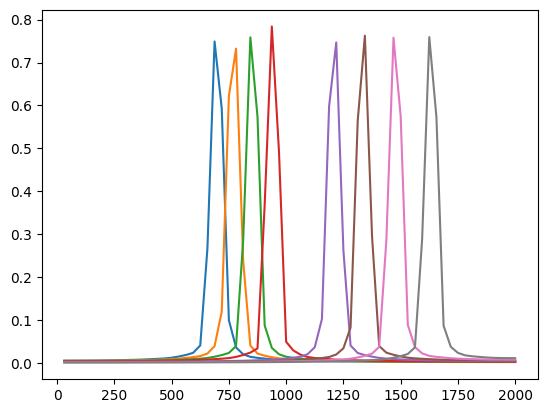

In [3]:
### TODO:
### 1. familiarize with librosa stft to compute powerspectrum
### 2. extract the critical bands from the power spectrum (ie. how much energy in the DTMF-related freq bins?)
### 3. define template vectors representing the state (see dtmf_tones)
### 4. for a new recording, extract critical bands and do DP do get state sequence
### 5. backtrack & collapse

### Notice: you will need a couple of helper functions...

SR = 4000
N_FFT = 128
THRESH_RATIO = 256

def power_spectrogram(y: np.ndarray, sr: float) -> np.ndarray:
    return abs(lr.stft(y=lr.resample(y, orig_sr=sr, target_sr=SR), n_fft=N_FFT)[1:, :])

LOWER_FREQS = sorted(list({t[1] for t in DTMF_TONES}))
HIGHER_FREQS = sorted(list({t[2] for t in DTMF_TONES}))

M = np.empty((len(LOWER_FREQS) + len(HIGHER_FREQS), N_FFT // 2))
for i, f in enumerate(LOWER_FREQS):
    spec = np.sum(power_spectrogram(
        np.sin(np.arange(N_FFT) / SR * 2 * np.pi * f),
        SR
    )[:, 1:-2], axis=1)
    M[i, :] = spec / la.norm(spec)
for i, f in enumerate(HIGHER_FREQS):
    spec = np.sum(power_spectrogram(
        np.sin(np.arange(N_FFT) / SR * 2 * np.pi * f),
        SR
    )[:, 1:-2], axis=1)
    M[len(LOWER_FREQS) + i, :] = spec / la.norm(spec)

print("reference spectra:")
plt.plot(np.arange(1, M.shape[1] + 1) * SR / N_FFT, M.T)
plt.show()

def compute_features(y: np.ndarray, sr: float):
    spectrogram = power_spectrogram(y, sr)
    power = la.norm(spectrogram, axis=0).reshape(1, -1)    
    return  np.vstack([power, M @ spectrogram / (power + 1e-24)])

LOOKUP = {f1: {f2: "" for f2 in HIGHER_FREQS} for f1 in LOWER_FREQS}
for s, f1, f2 in DTMF_TONES:
    LOOKUP[f1][f2] = s

def decode_col(y: np.ndarray, thresh: float):
    if y[0] < thresh:
        return "\n"
    i = np.argmax(y[1 : len(LOWER_FREQS) + 1])
    j = np.argmax(y[1 + len(LOWER_FREQS) :])
    return LOOKUP[LOWER_FREQS[i]][HIGHER_FREQS[j]]

def decode(y: np.ndarray, sr: float) -> list[str]:
    """
    Apply DTMF signal decoding.
    
    Arguments:
    y: Input signal.
    sr: Sample rate. 
    
    Returns list of DTMF-signals (no silence).
    """
    ### YOUR CODE HERE
    
    features = compute_features(y, sr)
    thresh = max(features[0, :]).item() / THRESH_RATIO
    result = []
    pause = True
    for i in range(features.shape[1]):
        s = decode_col(features[:, i], thresh)
        if s == "\n":
            pause = True
        elif pause or result[-1] != s:
            result.append(s)
            pause = False
    return result
    
    ### END YOUR CODE

### Test the Decoding

In [4]:
TEST_FILE = "data/phone_number.wav"

y, sr = lr.load(TEST_FILE, sr=SR)
print(decode(y=y, sr=sr))

['0', '9', '1', '1', '5', '8', '8', '0', '1', '6', '5', '5']
